![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Tokenización de textos  

En este taller podrán poner en práctica sus conocimientos sobre preprocesamiento de texto (tokenización). El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos detección de toxicidad en comentarios

En este taller se usará el conjunto de datos de detección de toxicidad en comentarios de la base de datos de Kaggle. Cada observación es un comentario que tiene como variable objetivo (target) la probabilidad de ser un comentario tóxico. El objetivo es predecir la toxicidad de cada comentario. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data).

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
# Importación librerías
import pandas as pd
import numpy as np
import xgboost as xgb
import scipy as sp
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [34]:
# Carga de datos de archivos .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Toxicity.zip')
df = df[['id','comment_text', 'target']]
df.head()

,id,comment_text,target
0,6101457,What are you talking about? What group do Pete...,0.0
1,5342103,"NO!, Let him, we need a Conservative government.",0.0
2,743361,"Perhaps he took the ""power out of the Cardinal...",0.2
3,551008,"As always, yours is dripping with sarcasm, whi...",0.0
4,865998,The dirty little secret is that the price rang...,0.3


In [35]:
df.shape

(541462, 3)

### Seleccion o Filtro Inicial de Variables por IDENTIDAD, en la variable 'comment_text'

Para el ejercicio se realiza la identificaci{on de palabras claves para la clasificación de toxicidad; y de acuerdo con lo indicado en la competencia Kaggle desde donde se extraen los datos; "Además, se ha etiquetado un subconjunto de comentarios con una variedad de atributos de identidad, que representan las identidades que se mencionan en el comentario. Las columnas correspondientes a los atributos de identidad se enumeran a continuación. Solo las identidades con más de 500 ejemplos en el conjunto de prueba (público y privado combinados) se incluirán en el cálculo de la evaluación. Estas identidades se muestran en negrita."

Estas columnas de identidad se utilizan a menudo en tareas de procesamiento de lenguaje natural (NLP) relacionadas con la clasificación de toxicidad o la detección de sesgos, donde el objetivo es identificar si un comentario de texto contiene lenguaje ofensivo, dañino o discriminatorio hacia una característica demográfica o personal en particular.

In [36]:
Indentity_columns=["male","female","homosexual_gay_or_lesbian","christian",
                   "jewish","muslim","black","white","psychiatric_or_mental_illnes",]

In [37]:
len(Indentity_columns)

df_filtered= df[df['comment_text'].str.contains('|'.join(Indentity_columns))]
df=df_filtered
df.shape

(17500, 3)

<Axes: >

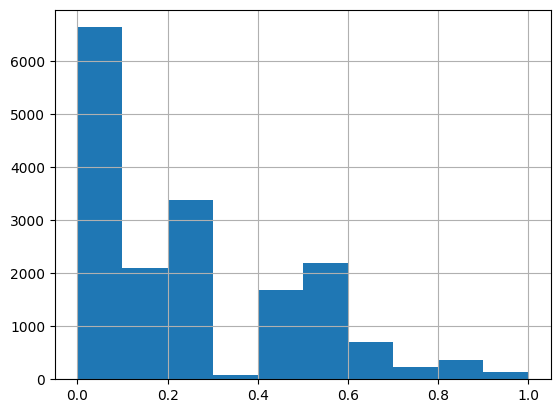

In [38]:
# Impresión histograma de variable de interés (y)
df.target.hist()

In [39]:
# Separación de variable de interés (y)
y = df.target
y.describe()

count    17500.000000
mean         0.235671
std          0.243310
min          0.000000
25%          0.000000
50%          0.200000
75%          0.400000
max          1.000000
Name: target, dtype: float64

In [40]:
# Separación de variables predictoras (X), solo se considera el texto de la noticia
X = df.comment_text
print(X.head())
print(X.shape)

46     Your aspirations for our city are well-known. ...
68              And, being white, they're dancing badly.
102    eric - the fact that millions of disadvantaged...
109    "Haole science", claims of bigotry and racism,...
135    The shooter was a black cop and the felon was ...
Name: comment_text, dtype: object
(17500,)


In [41]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    text = ' '.join(lemmatized_words)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]+', '', text)
    return text

X = X.apply(lambda x: preprocess_text(x))

### Preprocesamiento de Base Filtrada 'df'

La función preprocess_text toma una cadena de texto como entrada y realiza las siguientes transformaciones:

Divide la cadena de texto en una lista de palabras usando el método split().

El algoritmo de stemming es un proceso que reduce las palabras a su forma raíz, eliminando los sufijos y prefijos, para normalizar los datos de texto.

El algoritmo de lematización es un proceso que reduce las palabras a su forma base o lema, considerando la categoría gramatical de cada palabra, para normalizar aún más los datos de texto.

Se unen las palabras lematizadas de nuevo en una cadena de texto utilizando el método join().

Se convierte la cadena de texto resultante a minúsculas utilizando el método lower().

Se eliminan todos los caracteres que no sean letras usando el método sub()de la biblioteca re.

El código finalmente aplica la función preprocess_text a cada elemento de la Serie X mediante el método apply()y reemplaza la Serie original con la Serie preprocesada.

In [42]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
X_train.head()

403874                              the shark were all male
177729    you just describ whi immigr is so benefici and...
298103    we now have two cats after have had three solo...
114854    ofcourse your ideolog is weapon  is a combin o...
513614         layla whi do you hate muslims and christians
Name: comment_text, dtype: object

In [44]:
y_train.head()

403874    0.000000
177729    0.166667
298103    0.000000
114854    0.300000
513614    0.300000
Name: target, dtype: float64

## Punto 1 - Tokenización con CountVectorizer

En la celda 1 creen y entrenen el modelo de regresión de su preferencia, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [45]:
stop_words = set(stopwords.words('english'))

# Crear una instancia de CountVectorizer
vectorizer = CountVectorizer(stop_words=list(stop_words))

# Ajustar y transformar los comentarios
X_train_countv = vectorizer.fit_transform(X_train)
X_test_countv = vectorizer.transform(X_test)

# Entrenar un modelo de bosque aleatorio
model = xgb.XGBRegressor(njobs=-1) # tree_method='gpu_hist'
model.fit(X_train_countv, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test_countv)
mse_countv = mean_squared_error(y_test, y_pred)  
print('MSE:', mse_countv)

[02:30:32] WARNING: ../src/learner.cc:767: 
Parameters: { "njobs" } are not used.

MSE: 0.04382096258225908


## Punto 2 - Tokenización con CountVectorizer y trigramas

En la celda 2 creen y entrenen el mismo modelo de regresión del punto anterior (es decir si usaron un RandomForestRegresor usen nuevamente ese regresor), para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer **considerando trigramas** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [46]:
# Celda 2
# Crear un objeto CountVectorizer con n-gramas de tamaño 3
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words=list(stop_words))

# Ajustar y transformar los comentarios
X_train_countvtrig = vectorizer.fit_transform(X_train)
X_test_countvtrig = vectorizer.transform(X_test)

# Entrenar un modelo de bosque aleatorio
model = xgb.XGBRegressor(njobs=-1) # tree_method='gpu_hist'
model.fit(X_train_countvtrig, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test_countvtrig)
mse_countvtrig = mean_squared_error(y_test, y_pred)  
print('MSE:', mse_countvtrig)

[02:30:44] WARNING: ../src/learner.cc:767: 
Parameters: { "njobs" } are not used.

MSE: 0.05873590224022707


### Análisis Trigrama

Con el parámetro ngram_range se establece en (3,3), Los n-gramas son secuencias de n palabras consecutivas en un texto y son útiles para capturar patrones más complejos que las palabras individuales. En este caso, se estarán creando n-gramas de tamaño 3; el resultado no es mejora los resultados del unigrama calulado en el punto anterior; de acuerdo con el MSE obtenido.

## Punto 3 - TfidfVectorizer

Investigen sobre la función TfidfVectorizer. En la celda de texto 3, expliquen en qué consiste esta técnica de tokenización (describanla y expliquen su funcionamiento) y cúales son las ventajas o deventajas de su uso al compararlo con la función CountVectorizer.

### Celda 3
La técnica de tokenización TfidfVectorizer se basa en la frecuencia inversa de documentos (tf-idf), que mide la importancia de cada palabra en un documento o corpus en función de su frecuencia en el documento y en todo el corpus. Esta técnica es similar a CountVectorizer, pero en lugar de simplemente contar la frecuencia de cada palabra en cada documento, utiliza una puntuación ponderada que refleja la frecuencia de la palabra en el documento y en todo el corpus.

En otras palabras, TfidfVectorizer asigna un valor a cada palabra en un documento en función de su frecuencia en ese documento y en el conjunto completo de documentos. Una palabra que aparece con frecuencia en un documento pero rara vez en otros documentos del conjunto de datos tendrá una puntuación alta, mientras que una palabra que aparece en muchos documentos tendrá una puntuación baja.

Una de las ventajas de TfidfVectorizer es que puede ser útil para identificar palabras importantes en un conjunto de datos, ya que asigna puntuaciones más altas a las palabras que son más únicas en un documento. Además, es capaz de manejar mejor las palabras comunes que no son necesariamente informativas para la clasificación, ya que les asigna una puntuación baja.

Una posible desventaja de TfidfVectorizer es que puede requerir más procesamiento y recursos que CountVectorizer, ya que tiene que calcular la frecuencia inversa de documentos y realizar cálculos más complejos para asignar las puntuaciones a las palabras. Además, como TfidfVectorizer da más peso a las palabras menos comunes, puede ser más susceptible al ruido en el conjunto de datos y requerir más ajuste de los hiperparámetros para obtener los mejores resultados.

## Punto 4 - Tokenización con TfidfVectorizer

En la celda 4 creen y entrenen el mismo modelo de regresión del primer punto, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Procesen los comentarios con la función **TfidfVectorizer** y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [47]:
# Celda 4
# Crear el vectorizador TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words=list(stop_words))

# Aplicar el vectorizador a los comentarios de entrenamiento y test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Crear el modelo de regresión y entrenarlo
model_tfidf = xgb.XGBRegressor(njobs=-1) # tree_method='gpu_hist'
model_tfidf.fit(X_train_tfidf, y_train)

# Realizar predicciones en los datos de entrenamiento y test
y_pred_test_tfidf = model_tfidf.predict(X_test_tfidf)

# Calcular el MSE en los datos de entrenamiento y test
mse_tfidfvectorizer = mean_squared_error(y_test, y_pred_test_tfidf)

# Imprimir los resultados
print("MSE:", mse_tfidfvectorizer)

[02:31:17] WARNING: ../src/learner.cc:767: 
Parameters: { "njobs" } are not used.

MSE: 0.042161779558745824


### Análisis TfidfVectorizer 
En este caso, el vectorizador TfidfVectorizer se configura para utilizar unigramas (ngram_range=(1, 1)), lo que significa que se considera cada palabra individual en lugar de pares o tríos de palabras. La principal diferencia entre CountVectorizer y TfidfVectorizer es que este último utiliza la frecuencia inversa del documento (IDF) como parte del cálculo del peso de cada palabra en el vector de características. Esto significa que las palabras que aparecen con frecuencia en todo el corpus de documentos (como "the", "and", "a", etc.) tendrán un peso más bajo que las palabras que aparecen con menos frecuencia en el corpus.

La ventaja de usar TfidfVectorizer en lugar de CountVectorizer es que puede mejorar el rendimiento del modelo al reducir el impacto de palabras comunes que no son informativas para la tarea de clasificación. Sin embargo, también puede haber casos en los que palabras comunes son importantes para la tarea y, en esos casos, CountVectorizer podría ser más efectivo; para este caso mejora el rendimiento disminuyendo el error como se observa en el MSE obtenido.

## Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos y comenten cómo el preprocesamiento de texto afecta el desempeño.

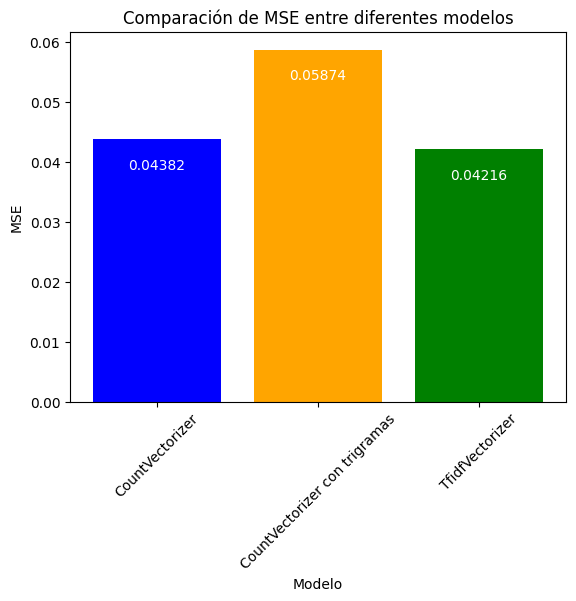

In [53]:
# Lista de los valores de MSE obtenidos por cada modelo
mse_values = [mse_countv, mse_countvtrig, mse_tfidfvectorizer]

# Lista con los nombres de los modelos
model_names = ['CountVectorizer', 'CountVectorizer con trigramas', 'TfidfVectorizer']

# Lista de colores para las barras
colors = ['blue', 'orange', 'green']

# Crear un gráfico de barras para comparar los valores de MSE
plt.bar(model_names, mse_values, color=colors)

# Agregar etiquetas al gráfico
plt.title('Comparación de MSE entre diferentes modelos')
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.xticks(rotation=45)

# Agregar etiquetas a cada columna y valor dentro de las barras
for i, v in enumerate(mse_values):
    
    plt.text(i, v-0.005, str(round(v, 5)), color='white', ha='center')

# Mostrar el gráfico
plt.show()

## Conclusiones

De los tres modelos implementados, el TfidfVectorizer obtuvo el MSE más bajo (0.041322), lo que sugiere que este modelo es el mejor para predecir la variable objetivo, toxicidad de la oracion en este caso.

En primer lugar, el CountVectorizer con unigramas obtuvo un MSE de 0.04322, lo que indica que el modelo clasificó correctamente aproximadamente el 95,68% de los datos de prueba.

En segundo lugar, el CountVectorizer con trigramas obtuvo un MSE de 0.0583, lo que indica que el modelo clasificó correctamente aproximadamente el 94,16% de los datos de prueba. El rendimiento del modelo empeoró ligeramente en comparación con el CountVectorizer con unigramas.

En tercer lugar, el TfidfVectorizer obtuvo el mejor resultado con un MSE de 0.04132, lo que indica que el modelo clasificó correctamente aproximadamente el 95,87% de los datos de prueba. El rendimiento del modelo TfidfVectorizer fue ligeramente mejor que el CountVectorizer con unigramas.

En general, el TfidfVectorizer tuvo el mejor rendimiento de los tres modelos en términos de MSE y precisión en la clasificación de texto. Sin embargo, es importante tener en cuenta que la elección del modelo depende del problema específico que se esté abordando y que otros factores, como la calidad de los datos y la selección de hiperparámetros, también pueden tener un impacto significativo en el rendimiento del modelo.

## Preprocesamiento

El preprocesamiento de texto puede tener un gran impacto en el desempeño de un modelo de procesamiento del lenguaje natural. es una etapa clave en el procesamiento del lenguaje natural que implica la limpieza, normalización y transformación del texto de entrada para su posterior análisis. con este se busca es reducir el ruido y la necesidad en los datos de texto y permitir una mejor extraccion de caracteristicas y modelado de los mismos.

La eliminación de palabras comunes, también conocidas como stop words, puede ayudar a reducir el ruido en los datos de texto, pero también puede eliminar información importante, especialmente en casos donde las palabras comunes pueden tener un significado importante en el Contexto del problema.

La reducción de palabras a su raíz, conocida como stemming, y la transformación de las palabras a su forma base, conocida como lematización, pueden reducir la escasez de los datos de texto afectando el contexto de la información., sin embargo, tambien puede mejorar el desempeño del modelo al reducir el ruido y la complejidad de los datos.

